In [7]:
from   global_def     import *
from EMAN2 import EMNumPy
import utilities as util
import sp_utilities
from sp_utilities    import get_params2D, set_params2D
from matplotlib import pyplot as plt

Implement GPU kernel via cupy.RawKernel

In [15]:
import cupy as cp

rot_scale_trans2D_background_kernel_pars = cp.RawKernel(r'''   
    __device__ inline float restrict2(float x, int nx) {
        while ( x >=  (float)(nx) )  x -= nx;
        while ( x <= -(float)(nx) )  x += nx;
        return x;
    }

    #define  fdata(i,j) fdata[ i-1 + (j-1)*nxdata ]
    __device__ inline float quadri_background(float xx, float yy, int nxdata, int nydata,
        float* fdata, int xnew, int ynew)
    {
        float  x, y, dx0, dy0, f0, c1, c2, c3, c4, c5, dxb, dyb;
        float  quadri;
        int    i, j, ip1, im1, jp1, jm1, ic, jc, hxc, hyc;

        x = xx;
        y = yy;

        // wrap around is not done circulantly; if (x,y) is not in the image, then x = xnew and y = ynew
        if ( (x < 1.0) || ( x >= (float)(nxdata+1) ) || ( y < 1.0 ) || ( y >= (float)(nydata+1) )){
              x = (float)xnew;
              y = (float)ynew;
        }


        i   = (int) x;
        j   = (int) y;

        dx0 = x - i;
        dy0 = y - j;

        ip1 = i + 1;
        im1 = i - 1;
        jp1 = j + 1;
        jm1 = j - 1;

        if (ip1 > nxdata) ip1 -= nxdata;
        if (im1 < 1)      im1 += nxdata;
        if (jp1 > nydata) jp1 -= nydata;
        if (jm1 < 1)      jm1 += nydata;

        f0  = fdata(i,j);
        c1  = fdata(ip1,j) - f0;
        c2  = (c1 - f0 + fdata(im1,j)) * 0.5f;
        c3  = fdata(i,jp1) - f0;
        c4  = (c3 - f0 + fdata(i,jm1)) * 0.5f;

        dxb = dx0 - 1;
        dyb = dy0 - 1;

        // hxc & hyc are either 1 or -1
        if (dx0 >= 0) hxc = 1; else hxc = -1;
        if (dy0 >= 0) hyc = 1; else hyc = -1;

        ic  = i + hxc;
        jc  = j + hyc;

        if (ic > nxdata) ic -= nxdata;  else if (ic < 1) ic += nxdata;
        if (jc > nydata) jc -= nydata;  else if (jc < 1) jc += nydata;

        c5  =  ( (fdata(ic,jc) - f0 - hxc * c1 - (hxc * (hxc - 1.0f)) * c2
            - hyc * c3 - (hyc * (hyc - 1.0f)) * c4) * (hxc * hyc));


        quadri = f0 + dx0 * (c1 + dxb * c2 + dy0 * c5) + dy0 * (c3 + dyb * c4);

        return quadri;
    }
    #define M_PI 3.14159265358979323846f
    extern "C" __global__
    void rot_scale_trans2D_background(float* dst, float* src, int nx, int ny, int c,
        float* angDeg, float* delx, float* dely, float* scale) 
    {
        int ix = blockIdx.x * blockDim.x + threadIdx.x;
        int iy = blockIdx.y * blockDim.y + threadIdx.y;
        int  z = blockIdx.z * blockDim.z + threadIdx.z;
        
        if (ix < nx && iy < ny && z < c) {

            src = &src[nx * ny * z];
            dst = &dst[nx * ny * z];

            float ang=angDeg[z]*M_PI/180.0f;

            if (0.0f == scale[z]) scale[z] = 1.0f; // silently fix common user error

            delx[z] = restrict2(delx[z], nx);
            dely[z] = restrict2(dely[z], ny);

            // center of image
            int xc = nx/2;
            int yc = ny/2;
            // shifted center for rotation
            float shiftxc = xc + delx[z];
            float shiftyc = yc + dely[z];
            // trig
            float cang = cos(ang);
            float sang = sin(ang);

            float y = float(iy) - shiftyc;
            float ycang = y*cang/scale[z] + yc;
            float ysang = -y*sang/scale[z] + xc;

            float x = float(ix) - shiftxc;
            float xold = x*cang/scale[z] + ysang ;
            float yold = x*sang/scale[z] + ycang ;

            int pos = iy * nx + ix;
            float tmp = quadri_background(xold+1.0f, yold+1.0f, nx, ny, src, ix+1, iy+1);
            //tmp = (tmp > 255) ? 255:tmp;
            //tmp = (tmp <   0) ?   0:tmp;
            dst[pos] = (float)tmp;
        }
    }
    ''', 'rot_scale_trans2D_background')

def rot_shift_2d_cupy(images, angDegs, delxs, delys , mirrors , scales , cids ):
    numref = int(max(cids)+1)
    cid = [int(cids[i]) for i in range(len(imgs))]
    in_gpu_array = cp.array(images)
    out_gpu_array = cp.zeros(in_gpu_array.shape, cp.float32)
    
    in_gpu_angDegs = cp.array(angDegs)
    in_gpu_delxs = cp.array(delxs)
    in_gpu_delys = cp.array(delys)
    in_gpu_scales = cp.array(scales)

    (c, h, w) = in_gpu_array.shape
    block = (16, 16, 4)
    grid = ((w + 15)//16, (h + 15)//16, (c+3)//4)
    rot_scale_trans2D_background_kernel_pars(grid, block,
                                       (out_gpu_array, in_gpu_array, w, h, c, 
                                        in_gpu_angDegs, in_gpu_delxs, in_gpu_delys, in_gpu_scales))
    start = 1 - h%2    
    for i in range(len(images)):
        if int(mirrors[i]) == 1:
            out_gpu_array[i][:,start:] = cp.flip(out_gpu_array[i][:,start:],1)
    gpu_aves = cp.zeros((numref, h, w), cp.float32)
    ## gpu to cpu
    for i in range(numref):
        gpu_aves[i] = cp.sum(out_gpu_array[[(i==cid[j]) for j in range(len(images))]], axis=0)

    aves = cp.asnumpy(gpu_aves)
    
    return aves

In [2]:
#from PIL import Image
import numpy as np
from fundamentals import  rot_shift2D
import sp_utilities
import sparx as spx

stack = './rib80s_ori_bin.hdf'
imgs = EMData.read_images(stack)

In [3]:
params = spx.read_text_row("./params.txt")

(105247, 105247)

In [5]:
%%time
nx = imgs[0].get_xsize()
refi = [ sp_utilities.model_blank(nx, nx, 1) for k in range(20)]
for i in range(len(imgs)):
    Util.add_img(refi[params[i][5]], rot_shift2D(imgs[i], params[i][1],params[i][2],params[i][3],params[i][4],1))

CPU times: user 14.2 s, sys: 2.26 ms, total: 14.2 s
Wall time: 14.2 s


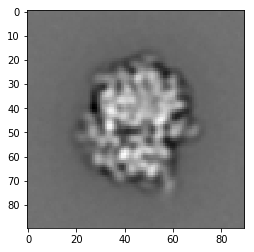

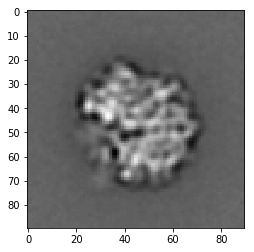

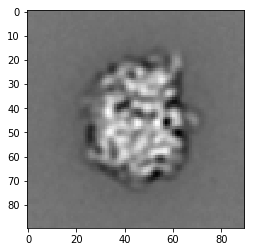

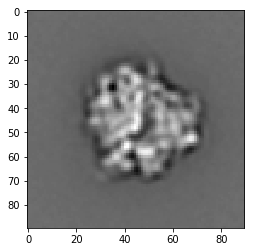

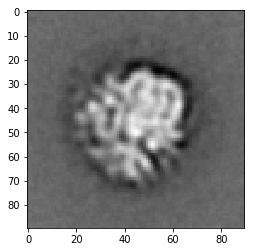

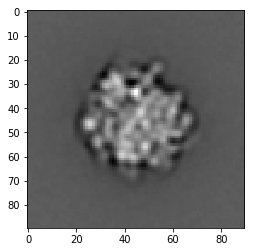

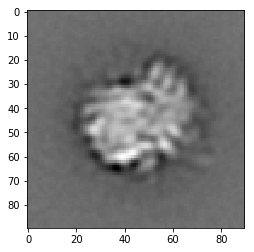

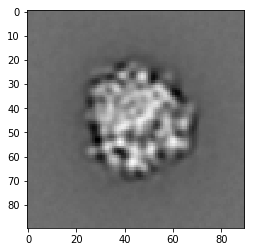

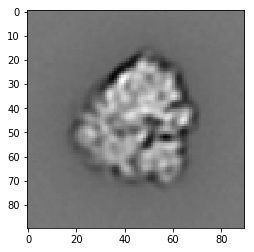

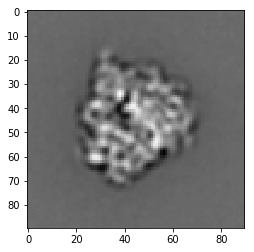

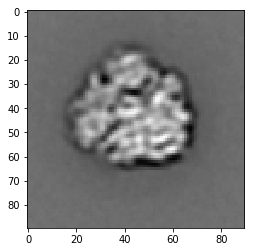

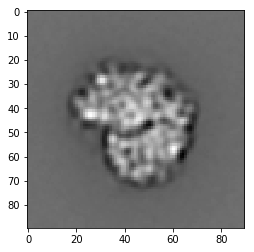

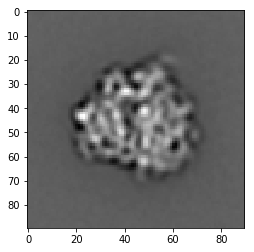

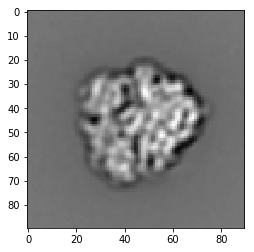

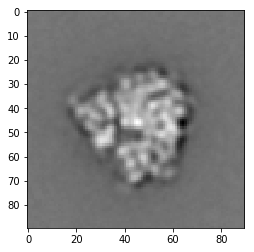

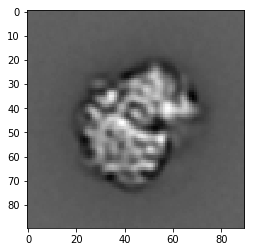

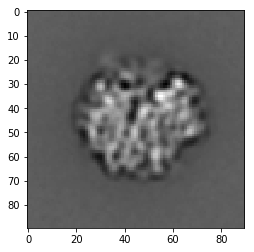

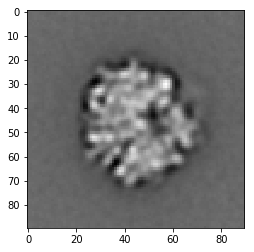

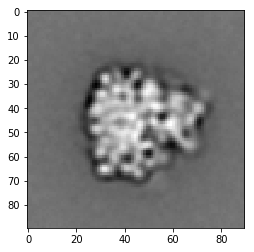

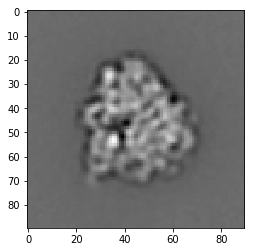

In [8]:
for i in range(20):
    plt.imshow(EMNumPy.em2numpy(refi[i]), cmap='gray')
    plt.show()

In [10]:
images = np.stack([imgs[i].numpy() for i in range(len(imgs))]).astype(np.float32)

In [16]:
%%time
params = np.array(params).astype(np.float32)
scales = np.array([1 for i in range(len(imgs))])
aves = rot_shift_2d_cupy(images, params[:,1], params[:,2], params[:,3], params[:,4], scales, params[:,5])

CPU times: user 2.51 s, sys: 342 ms, total: 2.85 s
Wall time: 2.94 s


In [17]:
for i in range(20):
    print(np.sum((aves[i] - refi[i].numpy())**2))

3.2531781
0.23090942
1.9962606
2.3798504
0.6985546
2.1996355
0.7968149
2.8896894
4.6747184
2.1413019
2.1073642
4.029273
3.4863372
5.0321884
2.6690457
13.36955
2.9196405
0.9865209
1.3976088
0.8985018


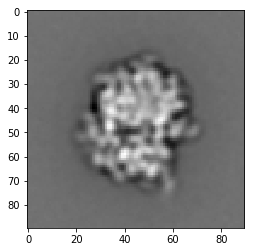

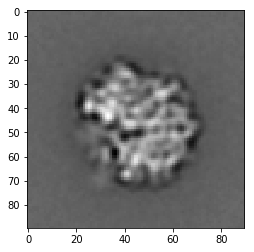

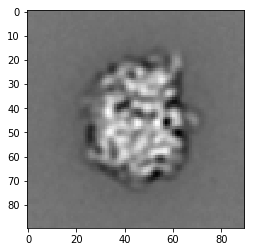

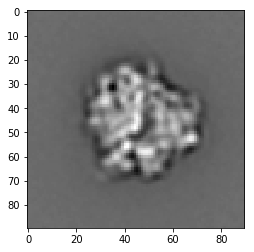

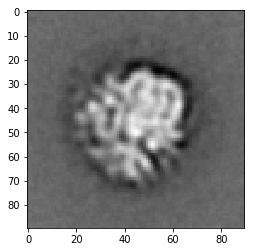

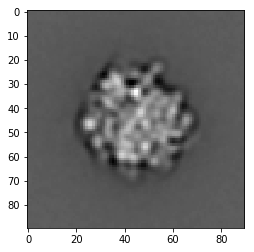

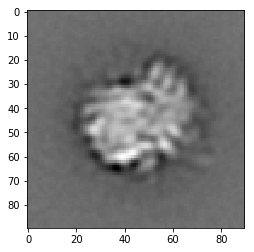

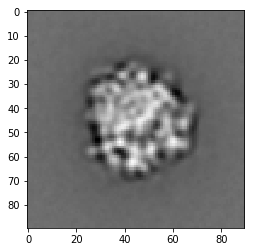

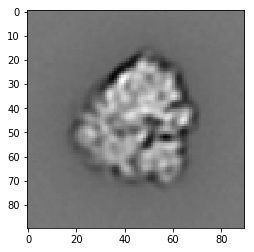

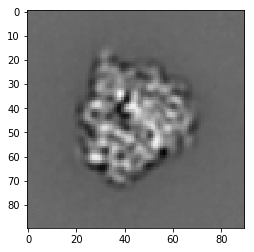

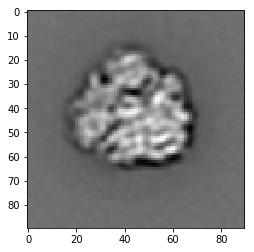

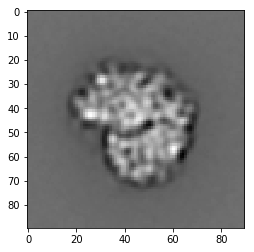

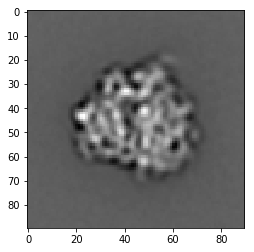

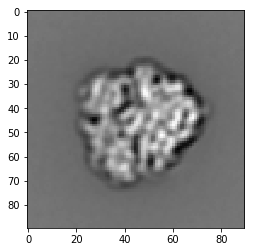

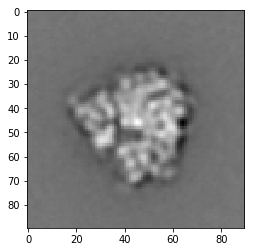

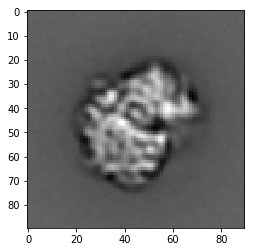

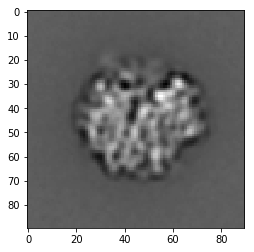

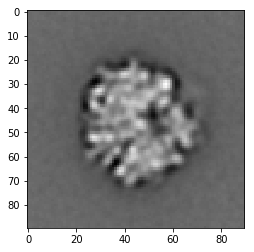

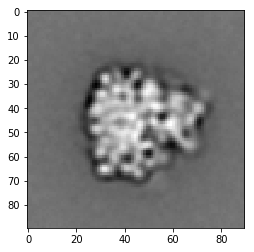

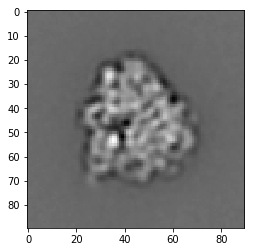

In [18]:
for i in range(20):
    plt.imshow(aves[i], cmap='gray')
    plt.show()